In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

import autograd.numpy as npa
from autograd import grad, value_and_grad

import legume
from legume import PlaneWaveExp, GuidedModeExp, Circle, ShapesLayer, Lattice, PhotCryst
from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

In [2]:
# PhC parameters
a = 420
ra = 0.5*256/a       # hole radius
eps_b = 3.453**2      # slab permittivity (n ~= 3.453 at low temp, n = 3.48 at room temp)
#eps_b = 11.7
eps_c = 1            # hole permittivity
d = 220/420          # slab thickness

# plane-wave expansion parameters
gmax = 2     # truncation of the plane-wave basis
Ny = 14      # Number of rows in the y-direction
Ny_opt = 3   # Number of rows in which the pillars will be modified
Nx = 1       # Supercell size in the x-direction

W = 0.94     # Waveguide Width (0.98 in Zhuang)

# Initialize a rectangular lattice
lattice = Lattice([Nx, 0], [0, (Ny+W-1)*np.sqrt(3)/2])

def wg_sc(dx, dy, dr):
    """Define the photonic crystal waveguide given shift parameters
    dx, dy, and dr, for the 2*Nx*Ny_opt number of pillars that get shifted
    """
    phc = PhotCryst(lattice, eps_l = 1, eps_u = 1)
    
    # Initialize a layer and the positions of the pillars for the regular waveguide
    phc.add_layer(d=d, eps_b=eps_b)
    
    xc = []; yc = []
    for ih in range(Ny):
        if ih != Ny//2:
            for ix in range(-Nx//2+1, Nx//2+1):
                xc.append((ih%2)*0.5 + ix)
                if ih <= Ny//2:
                    yc.append((-Ny//2 + ih + (1-W)/2)*np.sqrt(3)/2)
                else:
                    yc.append((-Ny//2 + ih - (1-W)/2)*np.sqrt(3)/2)

    # Add all the pillars, taking care of the shifts
    for ih in range(1, Ny//2+1):
        nx1 = (Ny//2+ih-1)
        nx2 = (Ny//2-ih)
        if ih <= Ny_opt:
            # The ih row includes "optimization" pillars
            for ix in range(Nx):
                circ = Circle(x_cent=xc[nx1*Nx + ix] + dx[(ih-1)*Nx + ix],
                              y_cent=yc[nx1*Nx + ix] + dy[(ih-1)*Nx  + ix],
                              r = ra + dr[(ih-1)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
                circ = Circle(x_cent=xc[nx2*Nx + ix] + dx[(ih-1+Ny_opt)*Nx  + ix],
                              y_cent=yc[nx2*Nx + ix] + dy[(ih-1+Ny_opt)*Nx  + ix],
                              r = ra + dr[(ih-1+Ny_opt)*Nx + ix], eps=eps_c)
                phc.add_shape(circ)
        else:
            # The ih row includes just regular pillars
            for ix in range(Nx):
                circ = Circle(x_cent = xc[nx2*Nx + ix], y_cent=yc[nx2*Nx + ix], r=ra, eps=eps_c)
                phc.add_shape(circ)
                if ih < Ny//2:
                    circ = Circle(x_cent = xc[nx1*Nx + ix], y_cent=yc[nx1*Nx + ix], r=ra, eps=eps_c)
                    phc.add_shape(circ)

    # Construct and return a plane-wave expansion object
    return phc

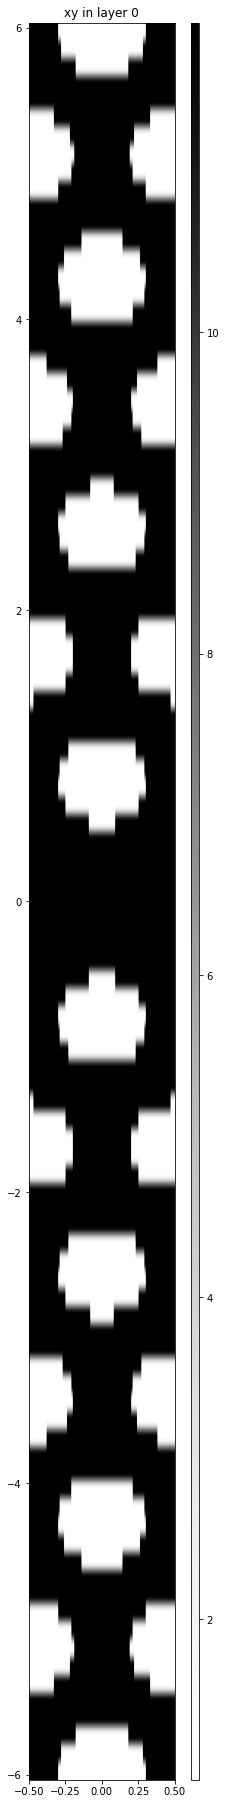

In [3]:
# Initialize zero shifts
dx0 = np.zeros((Nx*2*Ny_opt, ))
dy0 = np.zeros((Nx*2*Ny_opt, ))
dr0 = np.zeros((Nx*2*Ny_opt, ))

# Initialize the PWE and visualize the structure both through the `eps` and the `eps_ft` methods
phc0 = wg_sc(dx0, dy0, dr0)
legume.viz.structure(phc0, xz=False, xy=True, figsize=3)

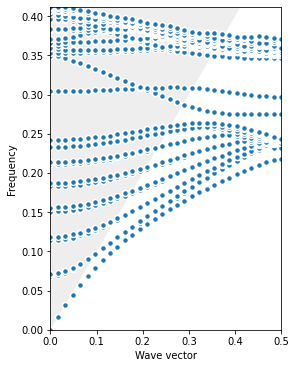

In [4]:
nk = 31

# Define a BZ path in kx
path = phc0.lattice.bz_path([[0, 0], np.array([np.pi/Nx, 0])], [nk])
#pwe0.run(kpoints=path['kpoints'], pol='tm', numeig = 150)

neig = 30

# Initialize GME
gme = legume.GuidedModeExp(phc0, gmax=gmax)

# Set some of the running options
options = {'gmode_inds': [0], 
           'numeig': neig,
           'verbose': False
            }

# Run the simulation
gme.run(kpoints=path['kpoints'], **options)

# Visualize the bands
ax = legume.viz.bands(gme, Q=False)

In [5]:
f_ind = np.linspace(0, 1, neig)
k = np.linspace(0, 0.5, nk+1)
fv, kv = np.meshgrid(f_ind, k)
# print(kv)
n_eff = kv/gme.freqs
wvln = a/gme.freqs

Text(0, 0.5, 'Effective Index $n_{eff}$')

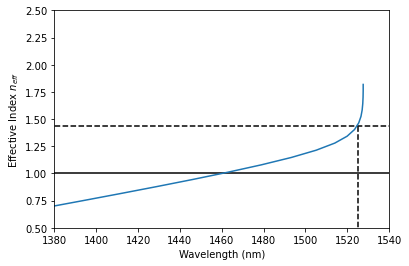

In [6]:
ind = 14 # Index of mode in question

plt.plot([1380,1540],[1,1],'k-')  # Light Line
plt.plot([0,10000],[1.44,1.44], 'k--') # Silica Index
plt.plot([1525,1525],[0,1.44], 'k--') # Wavelength in Question
plt.plot(wvln[:,ind], n_eff[:,ind])  
plt.xlim([1380,1540])
#plt.xlim([1650,1750])
plt.ylim([0.5,2.5])
plt.xlabel("Wavelength (nm)")
plt.ylabel(r"Effective Index $n_{eff}$")

In [7]:
n_target = 1.44
n_diff = n_target - n_eff[:,ind]
print(n_diff)

[ 1.44        1.38697736  1.33398801  1.28106438  1.22823724  1.17553493
  1.12298244  1.07060023  1.01840272  0.96639648  0.91457793  0.86293053
  0.81142139  0.75302343  0.69082916  0.62720886  0.56222266  0.49599664
  0.4287648   0.36093015  0.29312483  0.22618256  0.16088063  0.0975353
  0.03590226 -0.02451604 -0.08417367 -0.1433857  -0.20234438 -0.26115836
 -0.31988444 -0.37854787]


In [8]:
zero_crossings = np.where(np.diff(np.sign(n_diff)))
#print(np.sign(n_diff))
#print(np.diff(np.sign(n_diff)))
#print(zero_crossings)
print(wvln[zero_crossings, ind])

[[1523.4460447]]
